$$dX_t = A X_t dt + R_1 dW_t$$
$$dY_t = H X_t dt + R_2 dV_t$$

Model settings: (Conditions that the model needs to satsify)
1. Signal of dimension 'dim', and the observtations are in dimension 'dim_o'
2. $x_0|y_0 \sim N(m_0,C_0)$
3. $R_1, R_2$ is symmetric
4. $R_1$ is commutable with $A$
5. $(A+A')$ is invertible
6. For convenience purpose the target function is $\varphi(x)=x^{1}$, where $x=(x^{1},x^{2},...,x^{dim})$

In this code, I will include the $A,R_1,R_2,H,m_0,C_0$ as parameter as well, so that it's easily scalable wrt any dimension dim.
Note that dim needs to be bigger than 1, as the matrix multiplication sign '@' in python doesn't support '*' in one dimension.

First the input value for $A,R1,R2,H,m_0,C_0$ need to be folded into one variable.
One need to specify the model in the cell below first.

I should include the funciton $\varphi$ as well

Note - June 11th
One thing to keep in mind, is that the choice of R2 is quite important (we need a small R2 in order to have meaningful inference result, this could be demonstrated by simple simulation), another thing is that intuitively we would like to have observation of higher dimension than the signal. Heuristically this would allow us to have reasonable inference as well. Imagine we have 1000 dimensional signal but only one dimensional observation, then it would be impossible to get any information out.

In [53]:
import numpy as np
from scipy import linalg as la
from scipy.sparse import identity
from scipy.sparse import rand
from scipy.sparse import diags
from scipy.sparse import triu
## dim is dimension value
dim=10
dim_o=10
A1 = -rand(dim,dim,density=0.75).toarray()/5
A2 = triu(A1, k=1).toarray()/(10)
A = diags(np.random.normal(-0.5,0,dim),0).toarray()/50 + A2 - A2.T
## we denote R1^{1/2},R2^{1/2} as R1,R2 repectively for convenience
## Non-Identity covariance matrix
R1=(identity(dim).toarray() + np.tri(dim,dim,1) - np.tri(dim,dim,-2))/2
R2=(identity(dim_o).toarray() + np.tri(dim_o,dim_o,1) - np.tri(dim_o,dim_o,-2))/20

H=rand(dim_o,dim,density=0.75).toarray()/20
m0=np.zeros(dim)+6
C0=identity(dim).toarray()
## Collection of input 
collection_input = [dim,dim_o,A,R1,R2,H,m0,C0]

Data & Truth Gneration Function

In [2]:
def gen_data(T,l,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    tau=2**(-l)
    L=la.expm(A*tau)
    ## We are going to need W to be symmetric! 
    W=(R1@R1)@(la.inv(A+A.T)@(L@(L.T)-I))
    C=tau*H
    V=(R2@R2)*tau

    v=np.zeros((J+1,dim,1))
    z=np.zeros((J+1,dim_o,1))
    v[0]=np.random.multivariate_normal(m0,C0,(1)).T
    z[0]=np.zeros((dim_o,1))


    for j in range(J):
        ## truth
        v[j+1] = L@v[j] + np.random.multivariate_normal(np.zeros(dim),W,(1)).T
        ## observation
        z[j+1] = z[j] + C@v[j+1] + np.random.multivariate_normal(np.zeros(dim_o),V,(1)).T
        
    return([z,v])

Cut & Trim Function

In [3]:
def cut(T,lmax,l,v):
    ind = np.arange(T*2**l+1)
    rtau = 2**(lmax-l)
    w = v[ind*rtau]
    return(w)

Kalman Bucy Filter

In [4]:
def KBF(T,l,lmax,z,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    tau=2**(-l)
    L=la.expm(A*tau)
    W=(R1@R1)@(la.inv(A+A.T)@(L@(L.T)-I))
    ## C: dim_o*dim matrix
    C=tau*H
    V=(R2@R2)*tau
    
    z=cut(T,lmax,l,z)
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    m[0]=6*np.ones((dim,1))
    c[0]=C0
    
    for j in range(J):
        ## prediction mean-dim*1 vector
        mhat=L@m[j]
        ## prediction covariance-dim*dim matrix
        chat=L@c[j]@(L.T)+W
        ## innovation-dim_o*1 vector
        d=(z[j+1]-z[j])-C@mhat
        ## Kalman gain-dim*dim_o vector
        K=(chat@(C.T))@la.inv(C@chat@(C.T)+V)
        ## update mean-dim*1 vector
        m[j+1]=mhat+K@d
        ## update covariance-dim*dim matrix
        c[j+1]=(I-K@C)@chat
        
    return([m,c])

Testing Floor: KBF

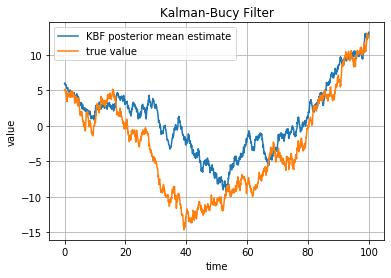

In [79]:
## test:good
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg as la
from scipy.sparse import identity
T=100
lmax=5
l=4
tau=2**(-l)
## The with numpy.errstate argument is used to avoid any stupid warning
with np.errstate(divide='ignore'):
    [z,v] = gen_data(T,lmax,collection_input)
    [m,c] = KBF(T,l,lmax,z,collection_input)
v=cut(T,lmax,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
plt.plot(x1,m[:,0],label="KBF posterior mean estimate")
plt.plot(x1,v[:,0],label="true value")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
plt.show()

Ensemble Kalman Bucy Filter Function ： Euler

In [5]:
def EnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    for j in range(J):
        dw = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
        dv = np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,N).T
        ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
        ## x-m[j]:dim*N c[j]:dim*dim
        
        step1=(((x-m[j]).T)@(H.T))
        step2=step1@(la.inv(R2)@la.inv(R2))
        step3=step2@( (z[j+1]-z[j]) - (H@x*dt + R2@dv) )
        step4=(x-m[j])@step3 /(N-1)
        
        x = x + A@x*dt + R1@dw + step4
        m[j+1] = (np.mean(x, axis=1)).reshape(dim,1)

    return([m,c])

Deterministic EnKBF function: DEnKBF - Euler

In [6]:
def DEnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**l)
    I=identity(dim).toarray()
    I_o=identity(dim_o).toarray()
    dt=2**(-l)
    
    m=np.zeros((J+1,dim,1))
    c=np.zeros((J+1,dim,dim))
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    for j in range(J):
        dw = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
        dv = np.random.multivariate_normal(np.zeros(dim_o),dt*I_o,N).T
        ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
        ## x-m[j]:dim*N c[j]:dim*dim
        
        step1=(((x-m[j]).T)@(H.T))
        step2=step1@(la.inv(R2)@la.inv(R2))
        # Only the "innovation" term here changes to the "deterministic" version
        step3=step2@( (z[j+1]-z[j]) - (H@(x+m[j])*dt)/2 )
        step4=(x-m[j])@step3 /(N-1)
        
        x = x + A@x*dt + R1@dw + step4
        m[j+1] = (np.mean(x, axis=1)).reshape(dim,1)

    return([m,c])

Testing Floor: EnKBF

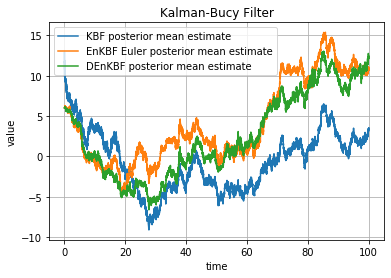

In [76]:
## test:good
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg as la
from scipy.sparse import identity
T=100
lmax=10
l=9
tau=2**(-l)
N=100
## The with numpy.errstate argument is used to avoid any stupid warning
with np.errstate(divide='ignore'):
    [z,v] = gen_data(T,lmax,collection_input)
    [m,c] = KBF(T,l,lmax,z,collection_input)
    [m1,c1] = EnKBF(T,l,lmax,z,N,collection_input)
    [m2,c2] = DEnKBF(T,l,lmax,z,N,collection_input)
v1=cut(T,lmax,l,v)
J=T*(2**l)
x1 = tau*np.arange(J+1)
plt.plot(x1,m[:,0],label="KBF posterior mean estimate")
#plt.plot(x1,v1[:,0],label="true value")
plt.plot(x1,m1[:,0],label="EnKBF Euler posterior mean estimate")
plt.plot(x1,m2[:,0],label="DEnKBF posterior mean estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
plt.show()

Coupled Ensemble Kalman Bucy Filter Function

In [8]:
def CEnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**(l-1))
    I=identity(dim).toarray()
    I1=identity(dim_o).toarray()
    dt=2**(-l)
    dt1=2**(-l+1)
    
    m=np.zeros((J*2+1,dim,1))
    m1=np.zeros((J+1,dim,1))
    c=np.zeros((J*2+1,dim,dim))
    c1=np.zeros((J+1,dim,dim))
    z1=cut(T,lmax,l-1,z)
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    x1 = x
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    m1[0]=m[0]
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    c1[0]=c[0]
    
    dw=np.zeros((2,dim,N))
    dv=np.zeros((2,dim_o,N))
    for j in range(J):
        for s in range(2):
            dw[s] = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
            dv[s] = np.random.multivariate_normal(np.zeros(dim_o),dt*I1,N).T
            ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
            ## x-m[j]:dim*N c[j]:dim*dim

            step1=(((x-m[2*j+s]).T)@(H.T))
            step2=step1@(la.inv(R2)@la.inv(R2))
            step3=step2@( (z[2*j+s+1]-z[2*j+s]) - (H@x*dt + R2@dv[s]) )
            step4=(x-m[2*j+s])@step3 /(N-1)

            x = x + A@x*dt + R1@dw[s] + step4
            m[2*j+s+1] = (np.mean(x, axis=1)).reshape(dim,1)
        
        step1=(((x1-m1[j]).T)@(H.T))
        step2=step1@(la.inv(R2)@la.inv(R2))
        step3=step2@( (z1[j+1]-z1[j]) - (H@x1*dt1 + R2@(dv[0]+dv[1])) )
        step4=(x1-m1[j])@step3 /(N-1)
        
        x1 = x1 + A@x1*dt1 + R1@(dw[0]+dw[1]) + step4
        m1[j+1] = (np.mean(x1, axis=1)).reshape(dim,1)
        
    return([m,m1])

Deterministic Coupled Ensemble Kalman Bucy Filter Function

In [9]:
def DCEnKBF(T,l,lmax,z,N,collection_input):
    
    [dim,dim_o,A,R1,R2,H,m0,C0]=collection_input
    J=T*(2**(l-1))
    I=identity(dim).toarray()
    I1=identity(dim_o).toarray()
    dt=2**(-l)
    dt1=2**(-l+1)
    
    m=np.zeros((J*2+1,dim,1))
    m1=np.zeros((J+1,dim,1))
    c=np.zeros((J*2+1,dim,dim))
    c1=np.zeros((J+1,dim,dim))
    z1=cut(T,lmax,l-1,z)
    z=cut(T,lmax,l,z)
    
    ## This gives a dim*N matrix
    x = np.random.multivariate_normal(m0,C0,N).T
    x1 = x
    ## A dim*1 vector
    m[0]=(np.mean(x, axis=1)).reshape(dim,1)
    m1[0]=m[0]
    ## dim*dim matrix
    c[0]=((x-m[0])@((x-m[0]).T)) /(N-1)
    c1[0]=c[0]
    
    dw=np.zeros((2,dim,N))
    dv=np.zeros((2,dim_o,N))
    for j in range(J):
        for s in range(2):
            dw[s] = np.random.multivariate_normal(np.zeros(dim),dt*I,N).T
            dv[s] = np.random.multivariate_normal(np.zeros(dim_o),dt*I1,N).T
            ## A@x:dim*N R1@dw:dim*N c[j]@(H.T):dim*dim_o z[j+1]-z[j]:dim_o*1 H@x*dt:dim_o*N R2*dv:dim_o*N 
            ## x-m[j]:dim*N c[j]:dim*dim

            step1=(((x-m[2*j+s]).T)@(H.T))
            step2=step1@(la.inv(R2)@la.inv(R2))
            step3=step2@( (z[2*j+s+1]-z[2*j+s]) - (H@(x+m[2*j+s])*dt)/2 )
            step4=(x-m[2*j+s])@step3 /(N-1)

            x = x + A@x*dt + R1@dw[s] + step4
            m[2*j+s+1] = (np.mean(x, axis=1)).reshape(dim,1)
        
        step1=(((x1-m1[j]).T)@(H.T))
        step2=step1@(la.inv(R2)@la.inv(R2))
        
        step3=step2@( (z1[j+1]-z1[j]) - (H@(x1+m1[j])*dt1)/2 )
        step4=(x1-m1[j])@step3 /(N-1)
        
        x1 = x1 + A@x1*dt1 + R1@(dw[0]+dw[1]) + step4
        m1[j+1] = (np.mean(x1, axis=1)).reshape(dim,1)
        
    return([m,m1])

Test Floor: Coupled Ensemble Kalman Bucy Filter

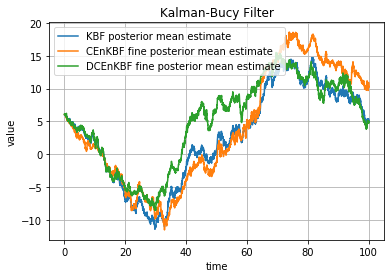

In [89]:
## test:good
import numpy as np
import matplotlib.pyplot as plt 
from scipy import linalg as la
from scipy.sparse import identity
T=100
lmax=6
l=6
N=50
tau=2**(-l)
## The with numpy.errstate argument is used to avoid any stupid warning
with np.errstate(divide='ignore'):
    [z,v] = gen_data(T,lmax,collection_input)
    [m,c] = KBF(T,l,lmax,z,collection_input)
    [m2,m3] = CEnKBF(T,l,lmax,z,N,collection_input)
    [m4,m5] = DCEnKBF(T,l,lmax,z,N,collection_input)
J=T*(2**l)
x1 = tau*np.arange(J+1)
x2 = 2**(-l+1)*np.arange(T*(2**(l-1))+1)
plt.plot(x1,m[:,0],label="KBF posterior mean estimate")

plt.plot(x1,m2[:,0], label="CEnKBF fine posterior mean estimate")
plt.plot(x1,m4[:,0],label="DCEnKBF fine posterior mean estimate")
#plt.plot(x2,m5[:,0],label="DCEnKBF coarse posterior mean estimate")
#plt.plot(x2,m3[:,0],label="CEnKBF coarse posterior mean estimate")

#plt.plot(x1,m4[:,0],label="EnKBF estimate")
plt.xlabel('time')
plt.ylabel('value')
plt.title('Kalman-Bucy Filter')
plt.legend()
plt.grid()
plt.show()

Below we will prceed to test the rate of the variance, or the value of $\beta_{1}$ in our notes
1. Variance is a metaphor, more precisely we mean:
   $$\mathbb{E}[ ((\eta^{N,l}-\eta^{N,l-1}-\eta^{l}+\eta^{l-1})\varphi)^2 ]$$
   This is a MSE-type 'variance'.
2. In order to get this MSE-type value, we would need an approximation of the 'true value' which is $(\eta^{l}-\eta^{l-1})(\varphi)$, I approximate this 'true value' with basically large ensemble number.
3. Once I have an estimate of the 'true value', repeat Coupled Ensemble Kalman Bucy Filter for Rep times and then take the average of the Rep suqared differences to be an estimate of the MSE-type 'variance' of interest.
4. To estimate the 'bias' rate $\beta_{2}$, we uses below term:
   $$\mathbb{E}[ |(\eta^{N,l}-\eta^{N,l-1}-\eta^{l}+\eta^{l-1})\varphi)| ]$$
   It's clear how we are going to deal with this one now.
5. Well from the inequality given in the notes, clearly a large $N$ gives a close estimate of 'true value'. And to estimate the bias we will need to get the 'true value', like it or not. 

Sanity check: does the actual variance drop as discretization level l grows?  Yes!

In [58]:
import progressbar
T=100
lmax=12
N=50
#[z,v]=gen_data(T,lmax,collection_input)
Rep=100
evar=np.zeros(10)
for l in range(4,10):
    est=np.zeros(Rep)
    pr = progressbar.ProgressBar(max_value=Rep).start()
    for rep in range(Rep):
        with np.errstate(divide='ignore'):
            [m,m1]=CEnKBF(T,l,lmax,z,N,collection_input)
        est[rep]=m[-1,0]-m1[-1,0]
        pr.update(rep+1)
    pr.finish()
    evar[l]=np.sum((est-np.mean(est))*(est-np.mean(est)))/(Rep-1)
    print('Covariance at level l=',l,'is',evar[l])

100% (100 of 100) |######################| Elapsed Time: 0:00:57 Time:  0:00:57
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Covariance at level l= 4 is 1.2030392292214624


100% (100 of 100) |######################| Elapsed Time: 0:01:54 Time:  0:01:54
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Covariance at level l= 5 is 0.6895113677670908


100% (100 of 100) |######################| Elapsed Time: 0:03:48 Time:  0:03:48
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Covariance at level l= 6 is 0.2721180178470024


100% (100 of 100) |######################| Elapsed Time: 0:07:40 Time:  0:07:40
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Covariance at level l= 7 is 0.1513627191994118


100% (100 of 100) |######################| Elapsed Time: 0:15:17 Time:  0:15:17
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Covariance at level l= 8 is 0.06740176349481428


100% (100 of 100) |######################| Elapsed Time: 0:30:11 Time:  0:30:11


Covariance at level l= 9 is 0.0398223562429567


Plot it out!

1.0141479231155257


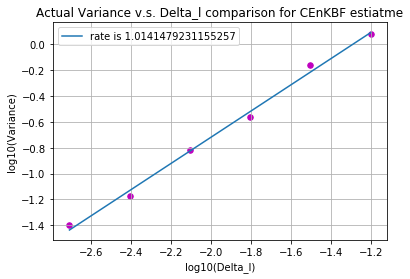

In [63]:
delt=np.zeros(10)
for l in range(10):
    delt[l]=2**(-l)
b = coef(np.log10(delt[4:10]),np.log10(evar[4:10]))
# plotting the actual points as scatter plot 
plt.scatter(np.log10(delt[4:10]), np.log10(evar[4:10]), color = "m", marker = "o", s = 30)
y_pred = b[0] + b[1]*np.log10(delt[4:10])
print(b[1])
plt.plot(np.log10(delt[4:10]),y_pred,label="rate is 1.0141479231155257")
plt.xlabel('log10(Delta_l)')
plt.ylabel('log10(Variance)')
plt.grid()
plt.legend()
plt.title('Actual Variance v.s. Delta_l comparison for CEnKBF estiatme')
plt.show()

DCEnKBF case

In [94]:
import progressbar
T=100
lmax=12
N=50
#[z,v]=gen_data(T,lmax,collection_input)
Rep=100
evar=np.zeros(10)
for l in range(4,10):
    est=np.zeros(Rep)
    pr = progressbar.ProgressBar(max_value=Rep).start()
    for rep in range(Rep):
        with np.errstate(divide='ignore'):
            [m,m1]=DCEnKBF(T,l,lmax,z,N,collection_input)
        est[rep]=m[-1,0]-m1[-1,0]
        pr.update(rep+1)
    pr.finish()
    evar[l]=np.sum((est-np.mean(est))*(est-np.mean(est)))/(Rep-1)
    print('Covariance at level l=',l,'is',evar[l])

100% (100 of 100) |######################| Elapsed Time: 0:00:58 Time:  0:00:58
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Covariance at level l= 4 is 0.6138322650472664


100% (100 of 100) |######################| Elapsed Time: 0:01:54 Time:  0:01:54
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Covariance at level l= 5 is 0.2019310772978208


100% (100 of 100) |######################| Elapsed Time: 0:03:51 Time:  0:03:51
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Covariance at level l= 6 is 0.09448377435963841


100% (100 of 100) |######################| Elapsed Time: 0:07:34 Time:  0:07:34
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Covariance at level l= 7 is 0.05043316378055039


100% (100 of 100) |######################| Elapsed Time: 0:14:55 Time:  0:14:55
N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Covariance at level l= 8 is 0.02796869841050989


100% (100 of 100) |######################| Elapsed Time: 0:30:49 Time:  0:30:49


Covariance at level l= 9 is 0.013933243410428122


1.050509568685716


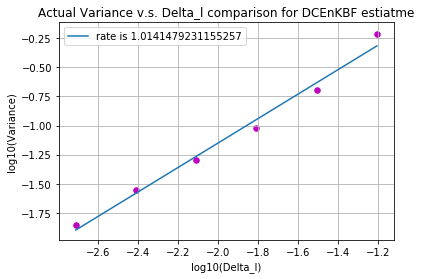

In [97]:
delt=np.zeros(10)
for l in range(10):
    delt[l]=2**(-l)
b = coef(np.log10(delt[4:10]),np.log10(evar[4:10]))
# plotting the actual points as scatter plot 
plt.scatter(np.log10(delt[4:10]), np.log10(evar[4:10]), color = "m", marker = "o", s = 30)
y_pred = b[0] + b[1]*np.log10(delt[4:10])
print(b[1])
plt.plot(np.log10(delt[4:10]),y_pred,label="rate is 1.0141479231155257")
plt.xlabel('log10(Delta_l)')
plt.ylabel('log10(Variance)')
plt.grid()
plt.legend()
plt.title('Actual Variance v.s. Delta_l comparison for DCEnKBF estiatme')
plt.show()

Linear Regression Function

In [10]:
import numpy as np 
import matplotlib.pyplot as plt 
  
def coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 

Compute approximated true value for $l=4,5,6,7,8,9$
1. Approximate the true value with EnKBF with large samples 

Compute approximated true value for $l=4,5,6,7,8,9$

2. Approximate the true value with DCEnKBF instead

Use the true value to calculate MSE-type Variance and Bias at various levels

1. For CEnKBF with Euler

Use the true value to calculate MSE-type Variance and Bias at various levels

2. For DCEnKBF

Above results show that for CEnKBF:
$\mathbb{E}[\Big((\eta_{t}^{l}-\eta_{t}^{l-1})^{N_{l}}-(\eta_{t}^{l}-\eta_{t}^{l-1})\Big)(\varphi)^2] = 692 \frac{\Delta_{l}^{1.04}}{N_{l}}$

for DCEnKBF:
$\mathbb{E}[\Big((\eta_{t}^{l}-\eta_{t}^{l-1})^{N_{l}}-(\eta_{t}^{l}-\eta_{t}^{l-1})\Big)(\varphi)^2] = 2089 \frac{\Delta_{l}^{1.03}}{N_{l}}$

Firstly, we want true value

One issue is with the $Var(\eta_{t}^{l,N})$, after checking this term actually doesn't drop with increasing $l$, which also seems to be the case in previous non-correlation noise case. One other thing to check to make sure the mechanism work is to see if this term drops with decreasing $N$, so that at least we could expect to use it.


Although the fact that this term doesn't drop with $l$ simply suggest that in higher dimensional cases, where the number of samples $N$ are very much limited under $100$, the entire ML-estimator will never perform better (have lower variance) than that offered by that of $(\eta_{t}^{l}(\varphi))^{N}$ for any given $l$.

Alternately, I simulate to see the relationship of $Var(\eta_{t}^{l,N})$ to $N$, as for the first level, l is not what we care about, we just want to choose the proper $N$.

Testing: If the actual variance of DEnKBF drops as N grows?

Have to resort to an unfitted truth, using N=2560's levelwise true value as reference, I get a rate of roughly -0.625.

At higher dimension I will just keep using this rate

$\mathbb{E}[\eta_{t}^{l}(\varphi) - \eta_{t}(\varphi)] = 53 \Delta_{l}^{0.9029} $

Bias save and load in here for $l \in \{0,1,2,3,4,5,6,7,8,9\}$

$|\mathbb{E}[\eta_{t}^{l}(\varphi) - \eta_{t}(\varphi)]| = 53 \Delta_{l}^{0.9029}$

Now we need to fit level-wise Variance, or $\mathbb{E}[(\eta_{t}^{l,N}(\varphi) - \eta_{t}^{l})^{2}]$, this term might be close to $Var(\eta_{t}^{l,N}(\varphi))$, but it's better that we simulate one round to check the similarity.

As the bias is actually fitted out, I guess we will have no choice but to use the variance to represent the "MSE" term, however simulation are still imperative as we want to test the EnKBF, noting that previous variance v.s. N simulation are done with DEnKBF (which shouldn't be used to fit the level-wise truth, obviously)

When $l=4$, for EnKBF

$\mathbb{E}[(\eta^{l,N}_{t}(\varphi) - \eta_{t}^{l}(\varphi))^2] \approx Var[\eta_{t}^{l,N}(\varphi)] = 408 N^{-1} $

When $l=5$, for EnKBF

$\mathbb{E}[(\eta^{l,N}_{t}(\varphi) - \eta_{t}^{l}(\varphi))^2] \approx Var[\eta_{t}^{l,N}(\varphi)] = 617 N^{-1} $

$l=7$ gives a result that is very similar to that of $l=4$, I think it's fair to use the result of $l=5$ as the slope is basically $-1$, which makes perfect sense

As a result, we decide to use unilaterally the constant, for EnKBF

$Var[\eta_{t}^{l,N}(\varphi)] = 617 N^{-1} \approx \mathbb{E}[(\eta_{t}^{l,N}(\varphi) - \eta_{t}^{l}(\varphi))^2]$

For DEnKBF, the hope is that this method guarentees $Var(\eta_{t}^{l,N})$ decreases with discretization level $l$: It doesn't

We could see clearly, after obtaining the approximate true value that the bias at level l=4 at least stabilize at 0.5 

As a result, we decide to use unilaterally the constant, for DEnKBF

$Var[\eta_{t}^{l,N}(\varphi)] = 700 N^{-1} \approx \mathbb{E}[(\eta_{t}^{l,N}(\varphi) - \eta_{t}^{l}(\varphi))^2]$

Through Langrange multiplier calculation, the exact number of particles for MLEnKBF are as such:
$$N_{3}=C 2^{1.8L}(617+(L-3)\sqrt{617*692/8})$$
$$N_{l}=C 2^{1.8L-l}(\sqrt{8*617*692}+(L-3)*692)\,\,\,\,\,\, l>3$$
where the constant $C$ should be chosen so that the "variance" of the ML estimator matches its suqare bias, which is $\Delta_{L}^{1.8}=2^{-1.8L}$
$$C \approx 1$$


For MLDEnKBF, the number of particles are:
$$N_{3}=C_{D} 2^{1.8L}(700+(L-3)\sqrt{700*2089/8})$$
$$N_{l}=C_{D} 2^{1.8L-l}(\sqrt{8*700*2089}+(L-3)*2089)\,\,\,\,\,\, l>3$$
where the constant $C$ should be chosen so that the "variance" of the ML estimator matches its suqare bias, which is $\Delta_{L}^{1.8}=2^{-1.8L}$

$$C_{D} \approx 4$$

Now, I could proceed to construct the ML estimator, finally. Simulations are of course required to determine the choice of $C$, but it would be good to get a little program to calcualte (unnormalized version of) $N_0$ and $N_l$ given $L$ and $l$.

For MLEnKBF: note that we need $L>3$

In [9]:
def Numcal(C,L):
    Num=np.zeros(L+1)
    Num[3]=C*2**(1.8*L)*(617+(L-3)*np.sqrt(617*692/8))
    Num[3]=int(Num[3])
    for li in range(4,L+1):
        Num[li]=C*2**(1.8*L-li)*(np.sqrt(617*692*8)+692*(L-3))
        Num[li]=int(Num[li])
    return(Num)

For MLDEnKBF: note that we need $L>3$

In [10]:
def Numcal_D(C,L):
    Num=np.zeros(L+1)
    Num[3]=C*2**(1.8*L)*(700+(L-3)*np.sqrt(700*2089/8))
    Num[3]=int(Num[3])
    for li in range(4,L+1):
        Num[li]=C*2**(1.8*L-li)*(np.sqrt(700*2089*8)+2089*(L-3))
        Num[li]=int(Num[li])
    return(Num)

Multilevel-Ensemble Kalman Bucy Filter Function

In [73]:
def MLEnKBF(C,T,L,lmax,z,collection_input):
    Num=Numcal(C,L)
    telescopic_summand=np.zeros(L-3+1)
    [m,c]=EnKBF(T,3,lmax,z,int(Num[3]),collection_input)
    telescopic_summand[0]=m[-1,0]
    for l in range(4,L+1):
        [m1,m2]=CEnKBF(T,l,lmax,z,int(Num[l]),collection_input)
        telescopic_summand[l-3]=m1[-1,0]-m2[-1,0]
    est=np.sum(telescopic_summand)
    return(est)

Multilevel-Deterministic Ensemble Kalman Bucy Filter Function

In [25]:
def MLDEnKBF(C,T,L,lmax,z,collection_input):
    Num=Numcal_D(C,L)
    telescopic_summand=np.zeros(L-3+1)
    [m,c]=DEnKBF(T,3,lmax,z,int(Num[3]),collection_input)
    telescopic_summand[0]=m[-1,0]
    for l in range(4,L+1):
        [m1,m2]=DCEnKBF(T,l,lmax,z,int(Num[l]),collection_input)
        telescopic_summand[l-3]=m1[-1,0]-m2[-1,0]
    est=np.sum(telescopic_summand)
    return(est)

Now we run & test the rate for MLEnKBF, we want to target different levels of accuracy $\mathcal{O}(\epsilon^2)=\Delta_{L}^{1.8}=2^{-(1.8L)}$, and compute it's cost $\sum_{l=3}^{L}\frac{N_{l}}{\Delta_{l}}$, we want to compare MLEnKBF with EnKBF

Now define cost functions for EnKBF and MLEnKBF

In [12]:
def cost_enkbf(l):
    kk=2**(2.8*l) * 617
    return(int(kk))
def cost_mlenkbf(C,L):
    num=Numcal(C,L)
    kk=0
    for l in range(3,L+1):
        kk=kk+num[l]*(2**(l))
    return(kk)

Cost function for DEnKBF and MLDEnKBF

In [13]:
def cost_denkbf(l):
    kk=2**(2.8*l) * 700
    return(int(kk))
def cost_mldenkbf(C,L):
    num=Numcal_D(C,L)
    kk=0
    for l in range(3,L+1):
        kk=kk+num[l]*(2**(l))
    return(kk)

Cost calculation for EnKBF and MLEnKBF

In [14]:
en_cost=np.zeros(9)
ml_cost=np.zeros(9)
C=0.0008
for l in range(4,9):
    en_cost[l]=cost_enkbf(l)
    ml_cost[l]=cost_mlenkbf(C,l)

Cost calculation for DEnKBF and MLDEnKBF

In [15]:
end_cost=np.zeros(9)
mld_cost=np.zeros(9)
C=0.0002
for l in range(4,9):
    end_cost[l]=cost_denkbf(l)
    mld_cost[l]=cost_mldenkbf(C,l)

Just to sum up:
1. en_cost is cost for EnKBF at each level
2. ml_cost is cost for MLEnKBF at each level
3. en_var is variance for EnKBF at each level
4. ml_var is variance for MLEnKBF at each level
5. bit is bias for both at each level
6. en_mse is MSE for EnKBF at each level
7. ml_mse is MSE for MLEnKBF at each level

Note that only levels 4,5,6,7,8 are simulated so the rest of the entries has no meaning

The "coef" function is used for linear regression

In [18]:
import numpy as np 
import matplotlib.pyplot as plt 
  
def coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 